In [19]:
import numpy as np

In [20]:
V = np.zeros((4,4))

In [21]:
def newStates(s1, s2):
    sl = (s1, s2-1) if s2-1 >= 0 else (s1, s2)
    sr = (s1, s2+1) if s2+1 <= 3 else (s1, s2)
    su = (s1-1, s2) if s1-1 >= 0 else (s1, s2)
    sb = (s1+1, s2) if s1+1 <= 3 else (s1, s2)
    return sl, sr, su, sb

In [22]:
totStates = [(x,y) for x in range(0,4) for y in range(0,4)]

In [23]:
totStates.pop(0)
totStates.pop(-1)

(3, 3)

In [24]:
for _ in xrange(500):
    for s, u in totStates:
        V[s,u] = 0.25*sum(-1+V[t] if (t != (0,0) and t != (3,3)) else V[t]
                       for t in newStates(s,u))

In [25]:
V

array([[  0., -13., -19., -21.],
       [-13., -17., -19., -19.],
       [-19., -19., -17., -13.],
       [-21., -19., -13.,   0.]])

## Jack's Car Rental

In [26]:
import matplotlib.pyplot as plt

In [27]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [28]:
from scipy.stats import poisson

In [29]:
import time

In [30]:
def cmpt_P_and_R(lambdaRequests,lambdaReturns,max_n_cars,max_num_cars_can_transfer):
    # the number of possible cars at any site first thing in the morning: 
    nCM = np.arange(0, max_n_cars+max_num_cars_can_transfer+1)
    # return the average rewards: 
    R = np.zeros(len(nCM))
    for n in nCM:
        tmp = 0.0 
        for nr in np.arange(0, (10*lambdaRequests+1)): # <- a value where the probability of request is very small. 
            tmp = tmp + 10*min(n,nr)*poisson.pmf(nr, lambdaRequests)
        R[n] = tmp 


    # return the probabilities: 
    P = np.zeros((len(nCM),max_n_cars+1)) 
    for nreq in np.arange(0, (10*lambdaRequests+1)):  #<- a value where the probability of request is very small. 
        reqP = poisson.pmf(nreq, lambdaRequests); 
        
        #for all possible returns:
        for nret in np.arange(0, (10*lambdaReturns+1)): # <- a value where the probability of returns is very small. 
            retP = poisson.pmf(nret, lambdaReturns)

            #for all possible morning states: 
            for n in nCM:
              sat_requests = min(n,nreq); 
              new_n = max( 0, min(max_n_cars,n+nret-sat_requests) )
              P[n,new_n] = P[n,new_n] + reqP*retP
    return R, P

 JCR_POLICY_EVALUATION - Performs policy evaluation evaluations returning the state-value function for the jacks car rental example.
 
  The Basic Algorithm is: Iterate the Bellman equation: 
 
  $$ V(s) = \sum_a \pi(s,a) \sum_{s'} P_{s,s'}^a (R_{s,s'}^a + \gamma V(s'))$$
 
  where the policy is given as input.  These iterations are done IN PLACE.
 
  See ePage 262 in the Sutton book.
 
  Input: 
    V = An array to hold the values of the state-value function 

In [96]:
def jcr_policy_evaluation(V,pol_pi,gamma,Ra,Pa,Rb,Pb,max_num_cars_can_transfer):
  
    # the maximum number of cars at each site (assume equal)
    max_n_cars = V.shape[0]-1;

    # the total number of states (including the states (0,Y) and (X,0)): 
    nStates = (max_n_cars+1)**2; 

    # some parameters for convergence: 

    MAX_N_ITERS = 100; iterCnt = 0; 
    CONV_TOL    = 1e-6;  delta = np.inf;  tm = np.NaN; 

    #---
    # MAIN policy evaluation loop: 
    #---
    print ('beginning policy evaluation ... \n'); 
    while( (delta > CONV_TOL) and (iterCnt <= MAX_N_ITERS) ) :
        delta = 0; 
        # For each state in \cal{S}:
        print 'delta:', delta
        for si in range(0, nStates): 
            # get the number of cars (ones based) at each site (at the END of the day): 
            
            [na1,nb1] = np.unravel_index( si, [ max_n_cars+1, max_n_cars+1 ] ); 
            na = na1; nb = nb1; # (zeros based) 
            #fprintf( 'prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', tm/60, si,na,nb ); 

            # get the old action value for this state: 
            v = V[na1,nb1] 

            # tranfer this many cars from A to B according to the poliy \pi: 
            ntrans = pol_pi[na1,nb1]; 

            #---
            # based on the state and action compute the expectation over 
            #     all possible states we may transition to i.e. s'
            # We need to consider 1) the number of possible returns at site A/B
            #                     2) the number of possible rentals at site A/B
            #---
            V[na1,nb1] = jcr_rhs_state_value_bellman(na,nb,ntrans,V,gamma,Ra,Pa,Rb,Pb,max_num_cars_can_transfer)

            delta = max([delta, abs( v - V[na1,nb1])]) 
            # end state loop 

        iterCnt=iterCnt+1;
        return V



In [97]:
def jcr_policy_improvement(pol_pi,V,gamma,Ra,Pa,Rb,Pb,max_num_cars_can_transfer):
  
    # the maximum number of cars at each site (assume equal): 
    max_n_cars = size(V,1)-1;

    # the total number of states (including the states (0,Y) and (X,0)): 
    nStates = (max_n_cars+1)**2; 

    # assume the policy is stable (until we learn otherwise below): 
    policyStable = 1; tm = NaN; 

    # For each state in \cal{S}:
    print ('beginning policy improvement...\n'); 
    for si in range(nStates): 
        # get the number of cars (ones based) at each site (at the END of the day): 
        [na1,nb1] = np.unravel_index( si, [ max_n_cars+1, max_n_cars+1 ]) 
        na = na1; nb = nb1; # (zeros based) 
    
        # our policy says in this state do the following: 
        b = pol_pi[na1,nb1]

#      are there any BETTER actions for this state?
#      --consider all possible actions in this state:
#      we can transfer up to na cars from site A to B
#      we can transfer up to nb cars from site B to site A (introducing a negative sign)
#      
#      It seemed there were various ways to interpret this problem: 
#      
#      1) assume the number of cars we can transfer is restricted only by the number we have
#      
        posA = min([na,max_num_cars_can_transfer])
        posB = min([nb,max_num_cars_can_transfer])
        posActionsInState = range(-posB,posA+1)
        npa = len(posActionsInState) 
        Q = -np.Inf*np.ones(npa)
        for ti in range(npa):
          ntrans = posActionsInState[(ti)]   

      #---
      # based on the state and action compute the expectation over 
      #     all possible states we may transition to i.e. s'
      # We need to consider 1) the number of possible returns at site A/B
      #                     2) the number of possible rentals at site A/B
      #---
          Q[ti] = jcr_rhs_state_value_bellman(na,nb,ntrans,V,gamma,Ra,Pa,Rb,Pb,max_num_cars_can_transfer)
    
        #check if this policy gives the best action
        dum = np.max( Q )
        imax = np.argmax(Q)
        maxPosAct  = posActionsInState[imax] 
        if( maxPosAct != b ):      # this policy in fact does NOT give the best action ...
          policyStable = 0 
          pol_pi[na1,nb1] = maxPosAct 
 
    print ('ended policy improvement...\n'); 
    return pol_pi, policyStable





In [98]:
def jcr_rhs_state_value_bellman(na,nb,ntrans,V,gamma,Ra,Pa,Rb,Pb,max_num_cars_can_transfer):
# RHS_STATE_VALUE_BELLMAN - computes the right hand side of the bellman equation

# We have to consider the possible number of rentals at sites A/B
#                  and the possible number of returns at sites A/B

     #the maximum number of cars at each site (assume equal): 
    max_n_cars = V.shape[0]-1; 

    # restrict this action: 
    ntrans = max(-nb,min(ntrans,na)); 
    ntrans = max(-max_num_cars_can_transfer,min(+max_num_cars_can_transfer,ntrans));

    v_tmp   = -2*abs(ntrans);
    na_morn = na-ntrans; 
    nb_morn = nb+ntrans; 
    #print max_n_cars, Pb.shape
    for nna in range(0, max_n_cars+1):
      for nnb in range(0, max_n_cars+1):
        pa = Pa[na_morn,nna] 
        pb = Pb[nb_morn,nnb] 
        v_tmp = v_tmp + pa*pb*(Ra[na_morn] + Rb[nb_morn] + gamma*V[nna,nnb]); 
    return v_tmp


In [99]:
gamma = 0.9; 
  
# the maximum number of cars we can store (overnight) at each site: 
max_n_cars = 20; 
#max_n_cars = 10; 
#max_n_cars = 5; 

max_num_cars_can_transfer = 5; 

# the parameters of the environment: 
if( 0 ):
  lambda_A_return = 3 # a debugging case: 
  lambda_A_rental = 3 
  lambda_B_return = 3 
  lambda_B_rental = 3; 
else:
  lambda_A_return = 3; 
  lambda_A_rental = 3; 
  lambda_B_return = 2; 
  lambda_B_rental = 4; 


In [100]:
# precompute the rewards and transition probabilities: 
[Ra,Pa] = cmpt_P_and_R(lambda_A_rental,lambda_A_return,max_n_cars,max_num_cars_can_transfer);
[Rb,Pb] = cmpt_P_and_R(lambda_B_rental,lambda_B_return,max_n_cars,max_num_cars_can_transfer);

In [101]:
# initial state value function: 
V = np.zeros((max_n_cars+1,max_n_cars+1))

# initial policy: 
pol_pi = np.zeros((max_n_cars+1,max_n_cars+1)); 

policyStable = 0; iterNum = 0;

In [113]:
V = jcr_policy_evaluation(V,pol_pi,gamma,Ra,Pa,Rb,Pb,max_num_cars_can_transfer);

# compute an improved policy using the most recent as a base: 
[pol_pi,policyStable] = jcr_policy_improvement(pol_pi,V,gamma,Ra,Pa,Rb,Pb,max_num_cars_can_transfer);

iterNum=iterNum+1; 

beginning policy evaluation ... 

delta: 0
beginning policy improvement...

ended policy improvement...



In [116]:
pol_pi

array([[ 0.,  0.,  0.,  0.,  0.,  0., -3., -4., -5., -5., -5., -5., -5.,
        -5., -5., -5., -5., -5., -5., -5., -5.],
       [ 0.,  0.,  0.,  0.,  0., -2., -3., -4., -5., -5., -5., -5., -5.,
        -5., -5., -5., -5., -5., -5., -5., -5.],
       [ 0.,  0.,  0.,  0., -1., -2., -3., -4., -4., -5., -5., -5., -5.,
        -5., -5., -5., -5., -5., -5., -5., -5.],
       [ 0.,  0.,  0.,  0., -1., -2., -3., -3., -4., -4., -5., -5., -5.,
        -5., -5., -5., -5., -5., -5., -5., -5.],
       [ 0.,  0.,  0.,  0., -1., -2., -2., -3., -3., -4., -4., -5., -5.,
        -5., -5., -5., -5., -5., -5., -5., -5.],
       [ 0.,  0.,  0.,  0., -1., -1., -2., -2., -3., -3., -4., -5., -5.,
        -5., -5., -5., -5., -5., -5., -5., -5.],
       [ 0.,  0.,  0.,  0.,  0., -1., -1., -2., -2., -3., -4., -5., -5.,
        -5., -5., -5., -5., -5., -5., -5., -5.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1., -1., -2., -3., -4., -4., -5.,
        -5., -5., -5., -5., -5., -5., -5., -5.],
       [ 0.,  0.,  0.,  

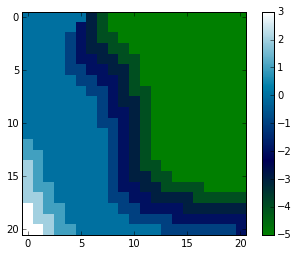

In [115]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(pol_pi, interpolation='nearest', cmap=plt.cm.ocean)
plt.colorbar()
plt.show()

beginning policy evaluation ... 



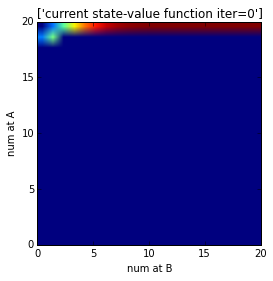

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.1165936787923178e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.014636993408203e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00011171897252400716, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 9.634892145792643e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.004803339640299e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00010361671447753907, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001489679018656413, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n

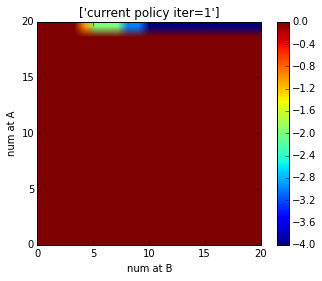

beginning policy evaluation ... 



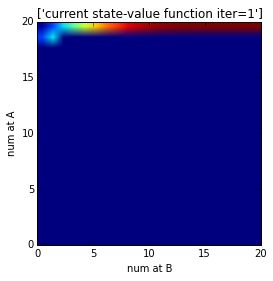

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.0182132720947267e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.1302700042724608e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 9.168386459350586e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 9.531577428181967e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00011308590571085612, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.446441014607747e-05, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00016266504923502604, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\

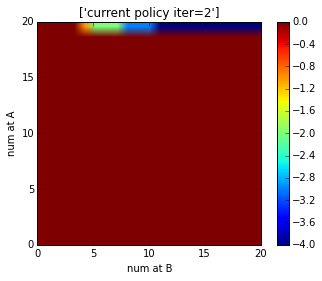

beginning policy evaluation ... 



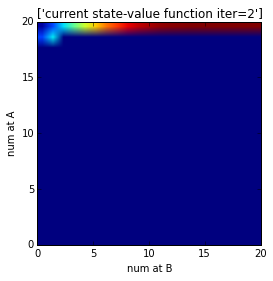

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0967254638671875e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.761948267618815e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 3.08990478515625e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00021681785583496093, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.09182612101237e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.371736526489258e-05, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0002222140630086263, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 

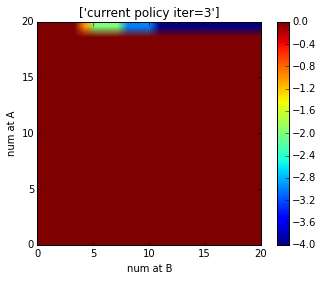

beginning policy evaluation ... 



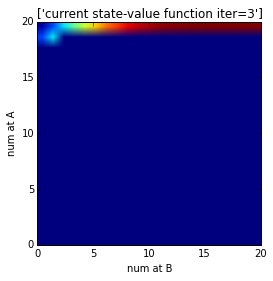

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0816256205240886e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.8712889353434244e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 9.255011876424154e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.2998790740966796e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00012960036595662436, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001381198565165202, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00017406543095906576, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...

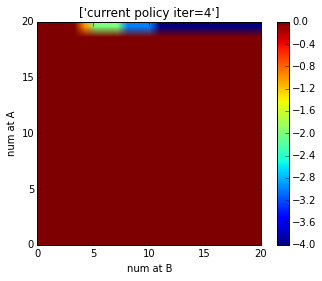

beginning policy evaluation ... 



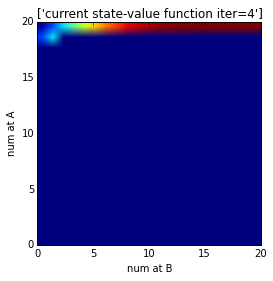

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.1416276295979818e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.0182132720947267e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00010666847229003906, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001938343048095703, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00012831687927246095, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00016771554946899415, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00013475020726521809, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)..

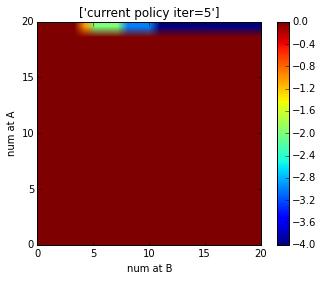

beginning policy evaluation ... 



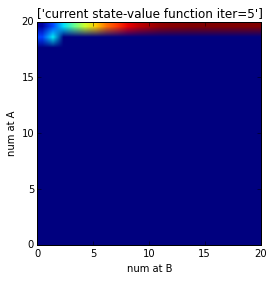

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0585784912109375e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.2232532501220703e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 9.786287943522135e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.3447812398274736e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00020381609598795573, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.401936213175455e-05, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.279945373535156e-05, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\

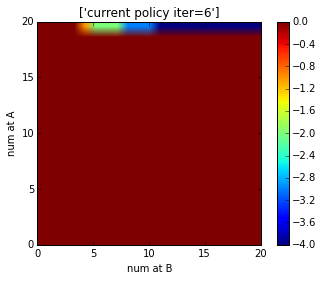

beginning policy evaluation ... 



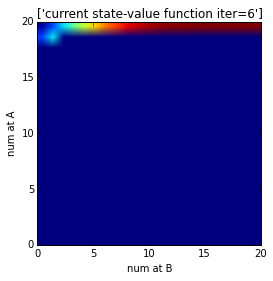

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.8785069783528646e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.1251042683919272e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 3.101825714111328e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00010066429773966471, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001367330551147461, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00013683636983235676, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001221338907877604, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\

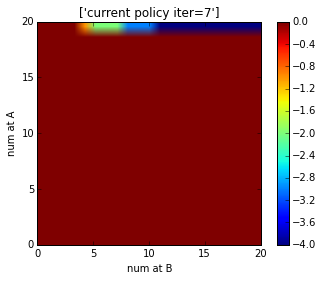

beginning policy evaluation ... 



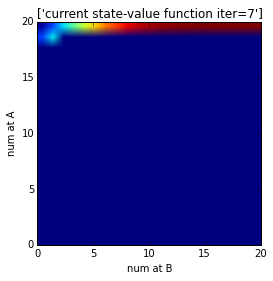

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.070102055867513e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00010201533635457357, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 3.435214360555013e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00021957953770955404, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.031824111938477e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00014496644337972004, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0002660830815633138, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n

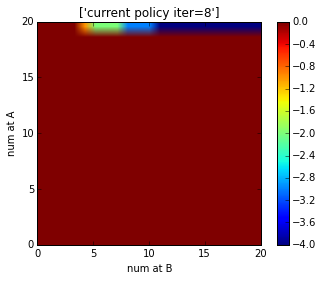

beginning policy evaluation ... 



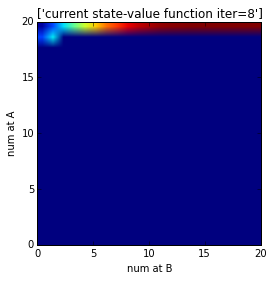

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0832150777180989e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.546808242797852e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00014139811197916668, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.4401486714680986e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 8.638302485148112e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001354813575744629, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00018094778060913087, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\

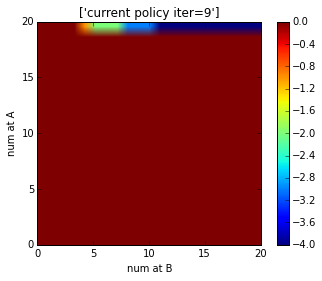

beginning policy evaluation ... 



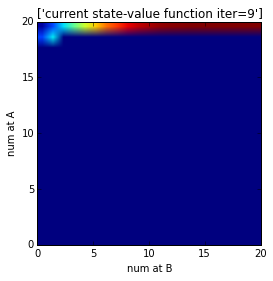

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0498364766438802e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.8833758036295576e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.1933854420979816e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.981922149658203e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.196730295817057e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00028640031814575195, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001470327377319336, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\

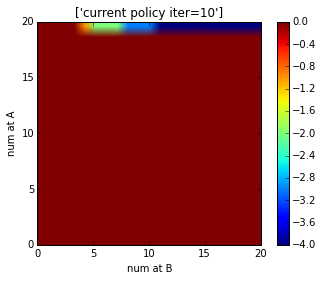

beginning policy evaluation ... 



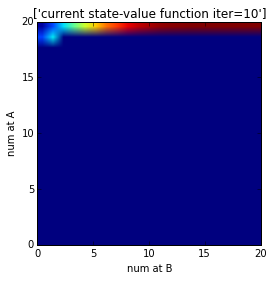

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.860228220621745e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.044836680094401e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001009662946065267, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 9.615023930867514e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001304189364115397, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00015628337860107422, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00011328458786010742, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n'

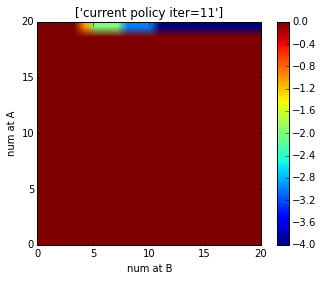

beginning policy evaluation ... 



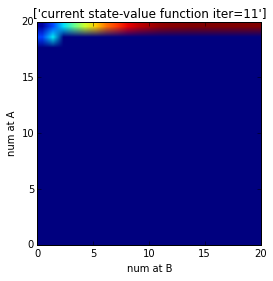

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0919570922851562e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.0432472229003907e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.9802322387695312e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00016986926396687826, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.046692530314128e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00015370051066080728, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00023683309555053711, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)..

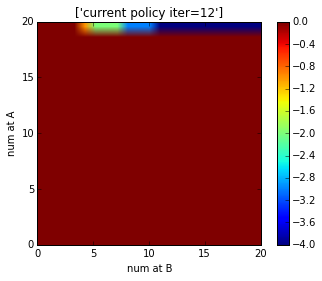

beginning policy evaluation ... 



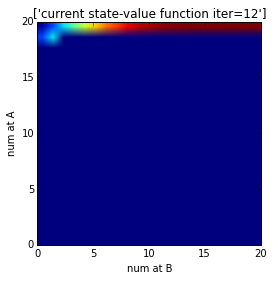

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.080036163330078e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.0531813303629556e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001817186673482259, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.0650367736816406e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.356636683146159e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.031592686971028e-05, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0002640684445699056, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n'

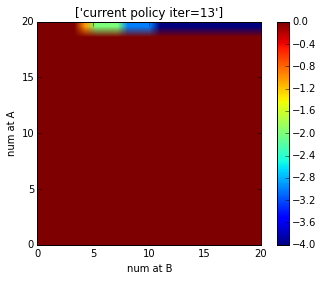

beginning policy evaluation ... 



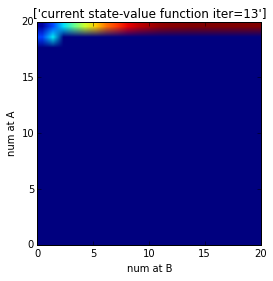

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0283788045247396e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.35822614034017e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 8.32676887512207e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00013038317362467448, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.233287811279297e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00020061731338500978, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001235167185465495, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n',

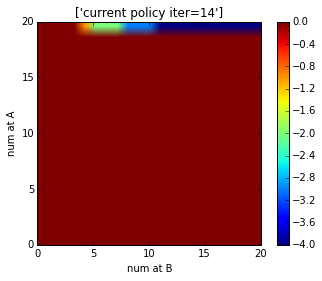

beginning policy evaluation ... 



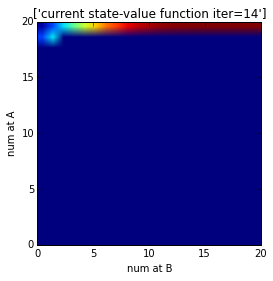

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0883808135986328e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.016955693562825e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 3.0199686686197918e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001363356908162435, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00012165307998657227, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00010051727294921876, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00021348396937052408, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...

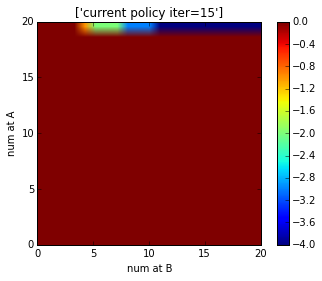

beginning policy evaluation ... 



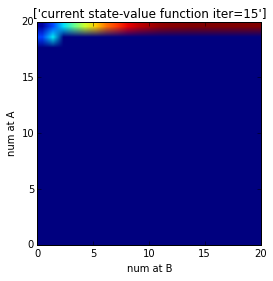

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.1584173838297524e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.115170160929362e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00013104677200317382, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.2951107025146486e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.041758219401042e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00013743241628011066, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00020896593729654949, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...

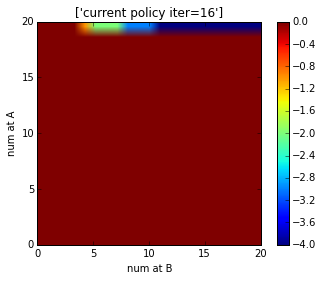

beginning policy evaluation ... 



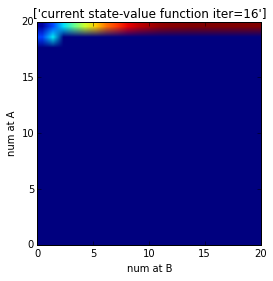

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0466575622558593e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.0766258239746092e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 7.174809773763021e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001139998435974121, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001235485076904297, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00018743276596069335, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.059805552164713e-05, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n

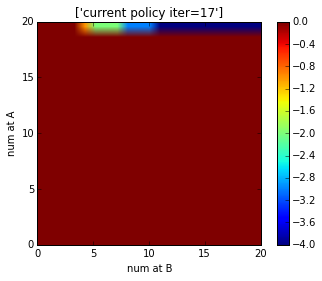

beginning policy evaluation ... 



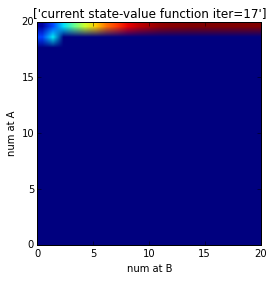

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.3050448099772135e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.113183339436849e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 3.2567977905273436e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.041592280069987e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00015685160954793294, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00012670358022054035, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00014710028966267904, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...

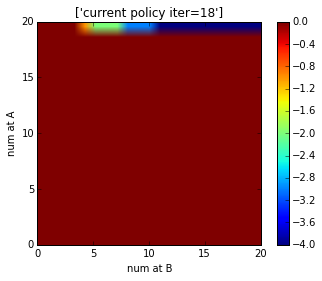

beginning policy evaluation ... 



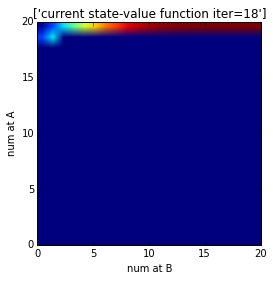

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.055002212524414e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 7.329781850179037e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.756848017374675e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 9.164810180664062e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 8.573134740193684e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00012831687927246095, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.986690521240234e-05, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n',

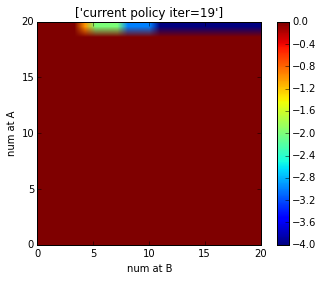

beginning policy evaluation ... 



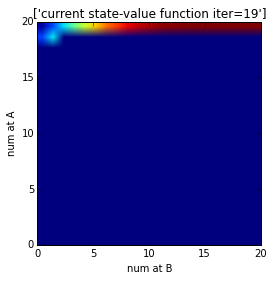

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0649363199869791e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 3.903309504191081e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 8.426507314046224e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.2382876078287764e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00012396971384684246, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00016695261001586914, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.203254063924154e-05, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\

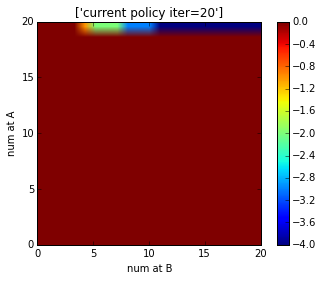

beginning policy evaluation ... 



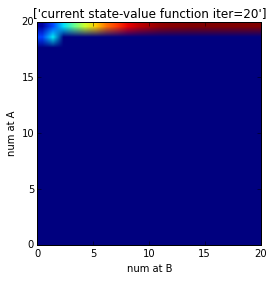

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.1150042215983073e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.208550771077474e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00013198455174763998, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.161596298217774e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.166530609130859e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00018805265426635742, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 8.603334426879883e-05, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n

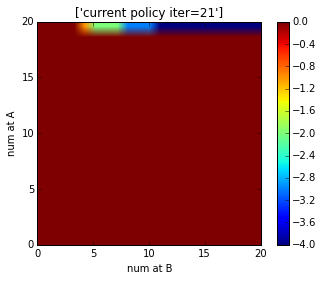

beginning policy evaluation ... 



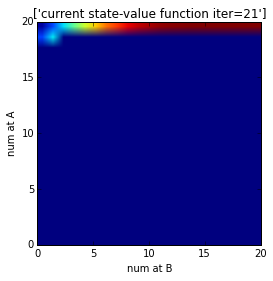

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.1285146077473959e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.0352999369303384e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 3.011624018351237e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00012798309326171874, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001427014668782552, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.12497329711914e-05, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0002492030461629232, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n'

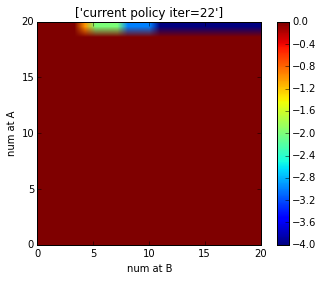

beginning policy evaluation ... 



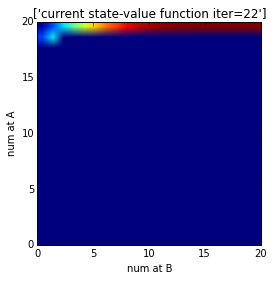

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0466575622558593e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 7.996559143066406e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.491740544637045e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 8.481740951538086e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.004803339640299e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001923680305480957, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001637140909830729, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n',

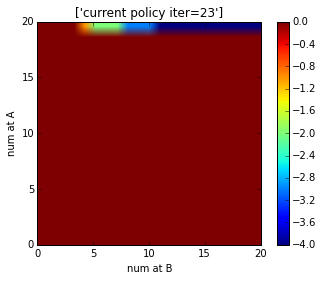

beginning policy evaluation ... 



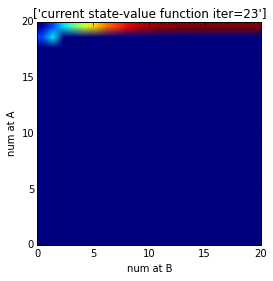

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0617574055989583e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.0380814870198568e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 3.0299027760823567e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00015828609466552734, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00010989904403686523, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001452167828877767, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.003379821777344e-05, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...

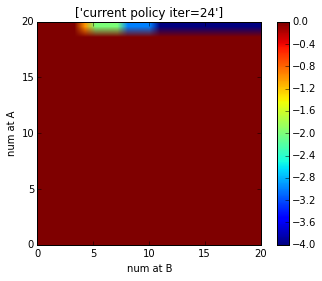

beginning policy evaluation ... 



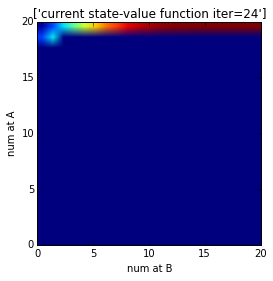

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0518232981363932e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.9951661427815756e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.79833984375e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.183451334635417e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00016104777654012045, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00017416874567667643, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00011565287907918294, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n',

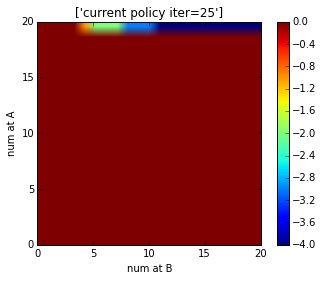

beginning policy evaluation ... 



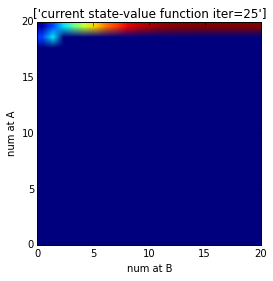

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.095136006673177e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.989768981933594e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 3.0068556467692056e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00010989904403686523, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001259167989095052, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00011465152104695638, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001893003781636556, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n

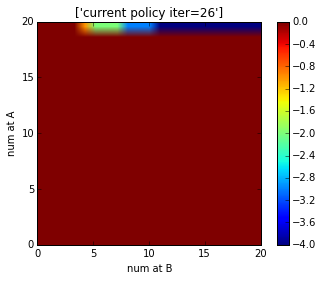

beginning policy evaluation ... 



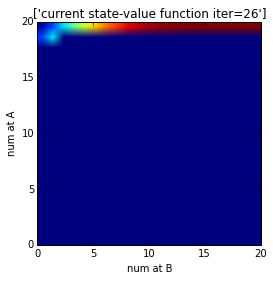

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0263919830322265e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.0813941955566406e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00010733207066853841, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 7.435083389282227e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00015168190002441407, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.270011266072592e-05, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00014711618423461913, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...

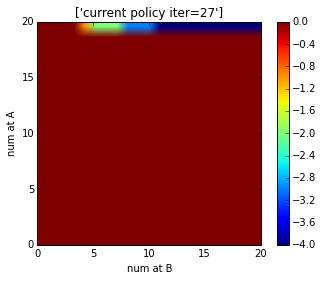

beginning policy evaluation ... 



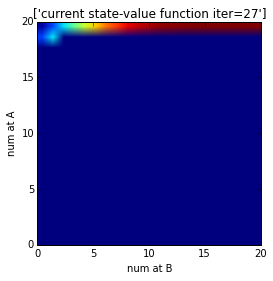

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 8.901755015055339e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.2431214650472004e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 3.113349278767904e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 9.298324584960938e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00011204878489176432, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00012093385060628256, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00015381574630737304, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\

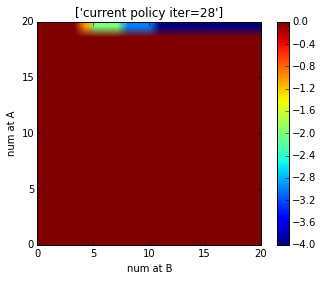

beginning policy evaluation ... 



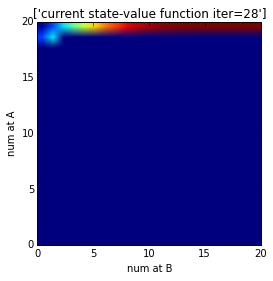

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0633468627929688e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.120335896809896e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 3.026723861694336e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 9.236733118693034e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00011125008265177409, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.97834587097168e-05, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00019568204879760742, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n'

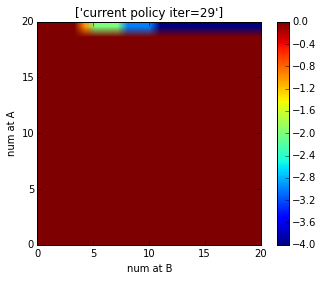

beginning policy evaluation ... 



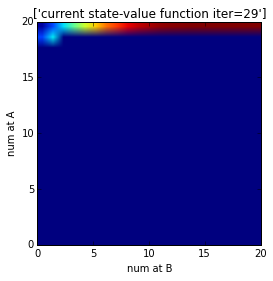

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.1563301086425781e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.0599365234375e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 3.0716260274251304e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 8.386373519897461e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00016001462936401367, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 7.983048756917317e-05, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00017728408177693686, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n'

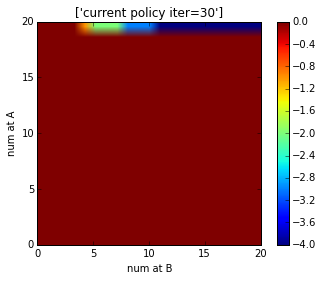

beginning policy evaluation ... 



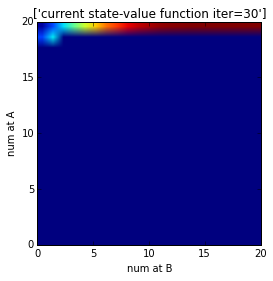

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0780493418375651e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.0531813303629556e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.066626230875651e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00019610325495402018, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001531680425008138, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.313323974609375e-05, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0002499818801879883, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n

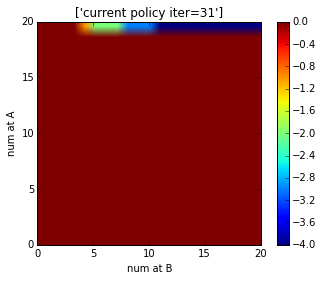

beginning policy evaluation ... 



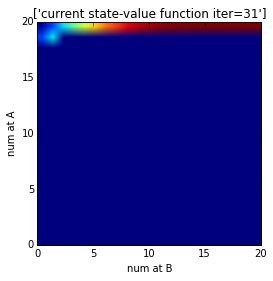

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.4349829355875654e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.3798147837320963e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.958477656046549e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00012055238087972005, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00022298494974772135, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00016463597615559895, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.501674652099609e-05, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...

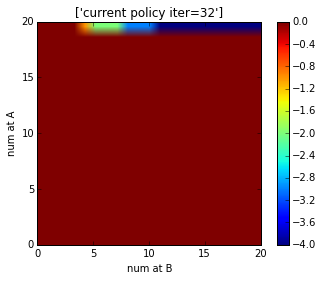

beginning policy evaluation ... 



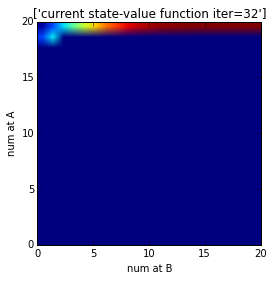

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0935465494791667e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.069870630900065e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001811345418294271, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.1480859120686846e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.296468734741211e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001529534657796224, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 9.485085805257161e-05, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n'

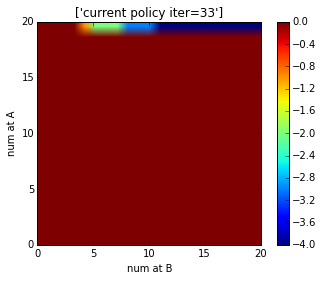

beginning policy evaluation ... 



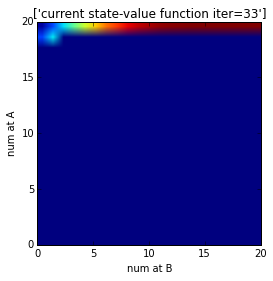

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.33143679300944e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.0802021026611328e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 7.006724675496419e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00014195044835408528, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.2881240844726565e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00012398163477579752, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00015771786371866862, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\

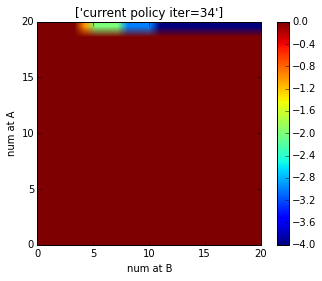

beginning policy evaluation ... 



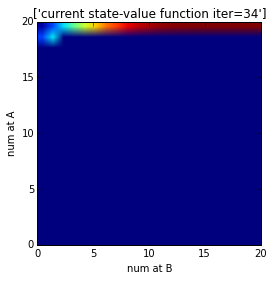

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 3.446340560913086e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 7.385015487670898e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 3.0402342478434245e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.033644994099935e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00012928247451782227, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00021053552627563475, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00014766454696655274, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\

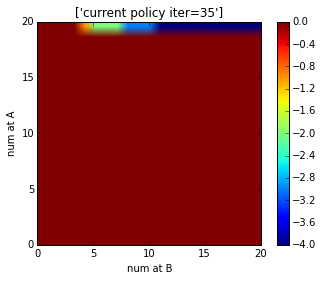

beginning policy evaluation ... 



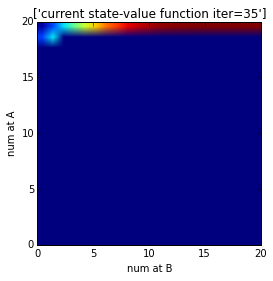

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0665257771809896e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.0885467529296874e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00012336572011311848, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.150072733561198e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00015454689661661785, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.9549013773600264e-05, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.0717264811197914e-05, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)..

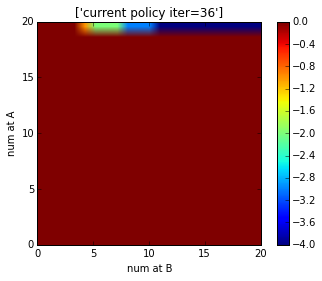

beginning policy evaluation ... 



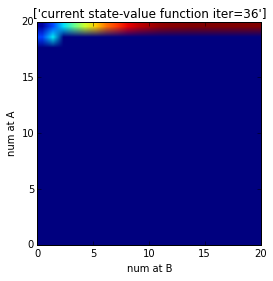

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 3.7097930908203124e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.0798047383626302e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 3.1216939290364584e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001421173413594564, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.0234794616699216e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.134907404581706e-05, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00014263391494750977, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...

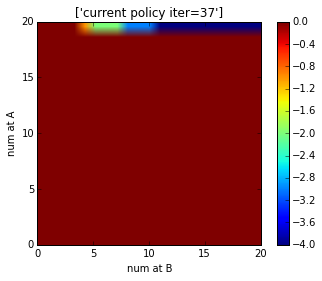

beginning policy evaluation ... 



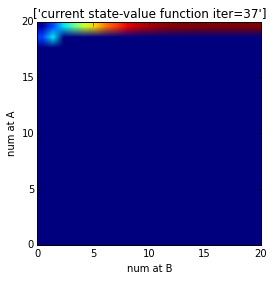

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0748704274495443e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.258618672688802e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 3.0513604482014974e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.233287811279297e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00013970136642456056, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 7.293224334716796e-05, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0002442161242167155, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n

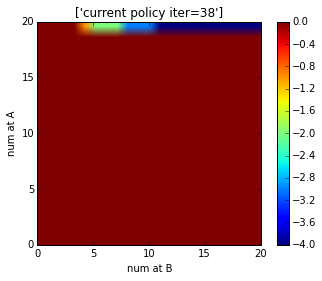

beginning policy evaluation ... 



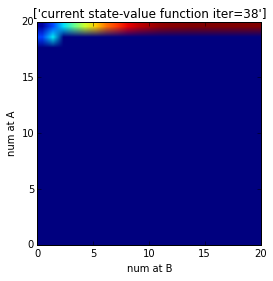

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.0102659861246744e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.575187047322592e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 3.10818354288737e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00010238488515218099, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00011359850565592447, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00015501976013183595, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00013658603032430013, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\

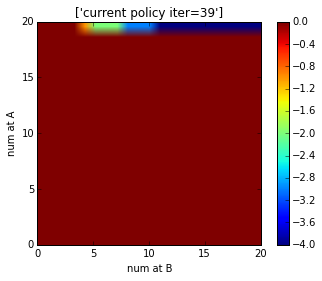

beginning policy evaluation ... 



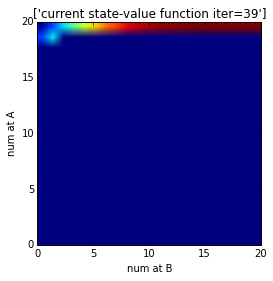

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.045068105061849e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.0265579223632812e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00015266736348470053, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.189809163411458e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 9.654760360717773e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00015628337860107422, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00014588435490926107, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\

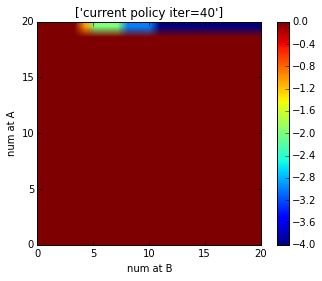

beginning policy evaluation ... 



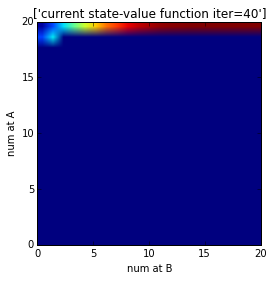

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.223519643147787e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.1616617838541668e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 3.018379211425781e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00011690060297648112, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 7.899999618530274e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0002987504005432129, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00019998550415039061, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n

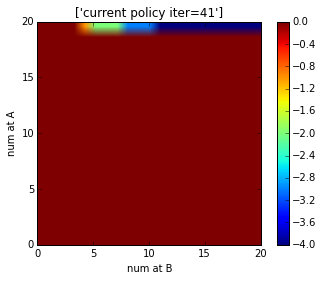

beginning policy evaluation ... 



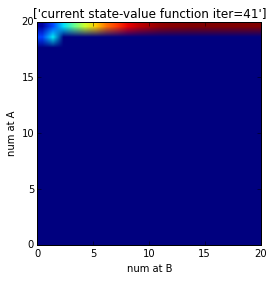

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.558563232421875e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.0666917165120444e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.9730796813964844e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00020751953125, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.289713541666667e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.169875462849936e-05, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0002369999885559082, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0

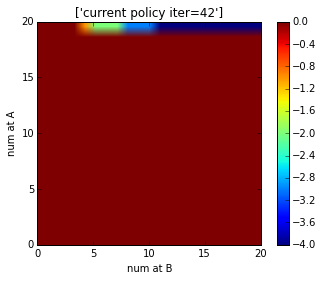

beginning policy evaluation ... 



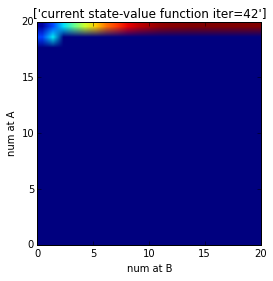

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.163482666015625e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00013203223546346028, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 7.789929707845052e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.030003229777018e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 9.589989980061849e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001114964485168457, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0002507845560709635, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n',

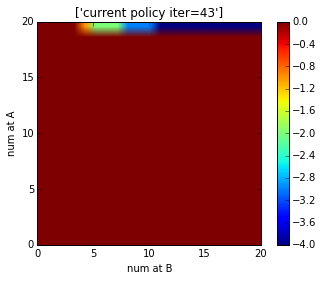

beginning policy evaluation ... 



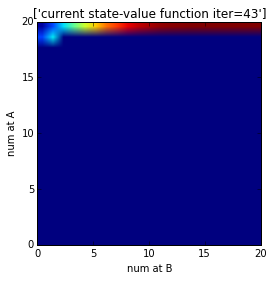

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.1583169301350912e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.0515918731689452e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00013343493143717447, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.234711329142253e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.061626434326172e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00013701518376668293, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00016303062438964843, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...

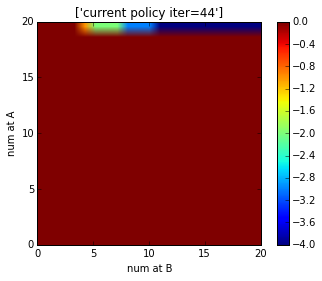

beginning policy evaluation ... 



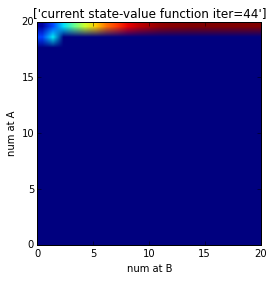

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0251998901367188e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.019802729288737e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.9818216959635416e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.0249029795328775e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.0063927968343096e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00013349850972493488, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00014434655507405598, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)..

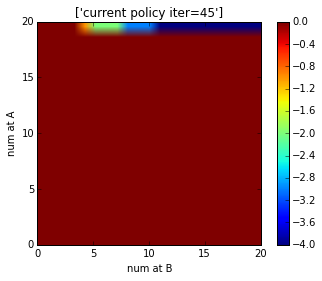

beginning policy evaluation ... 



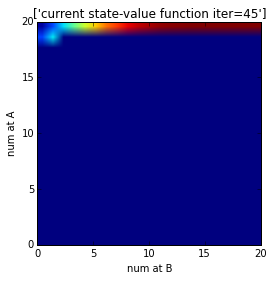

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0784467061360677e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 8.07801882425944e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00012616713841756184, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 8.68837038675944e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00011368195215861003, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00016787052154541016, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00011481841405232747, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n

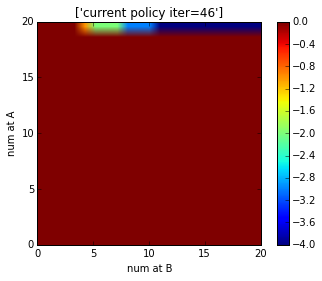

beginning policy evaluation ... 



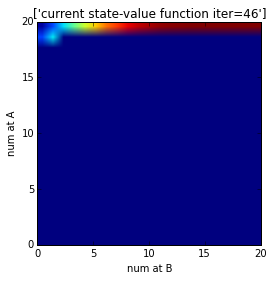

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0518232981363932e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00014770030975341797, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.944967269897461e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.104773203531901e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00016970237096150715, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 7.050037384033203e-05, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0003057678540547689, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n

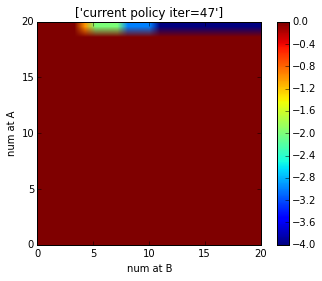

beginning policy evaluation ... 



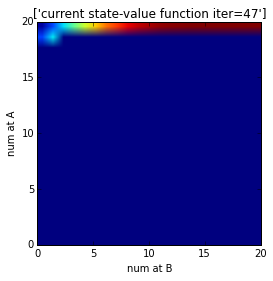

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.1197725931803386e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.153317133585612e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00025463104248046875, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00019965171813964843, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.051460901896159e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00013094743092854818, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00022569894790649414, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...

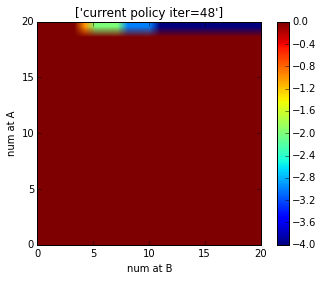

beginning policy evaluation ... 



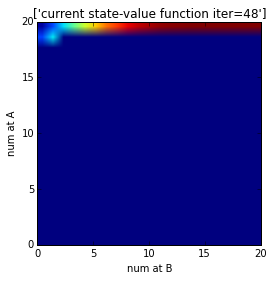

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0633468627929688e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.0015239715576173e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.9917558034261068e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0001497666041056315, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00015259981155395507, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.658236185709635e-05, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0002145687739054362, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\

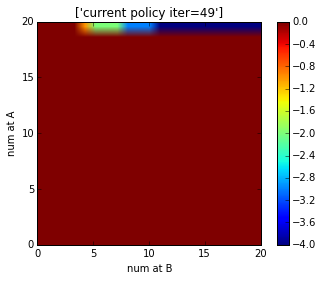

beginning policy evaluation ... 



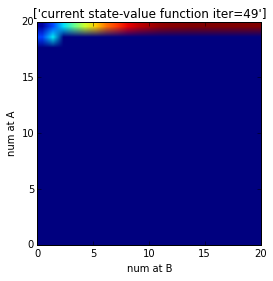

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0414918263753254e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.1135807037353517e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 3.08990478515625e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00010995070139567058, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.3501129150390626e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0002545317014058431, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.266832351684571e-05, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n

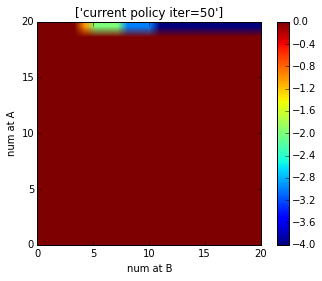

beginning policy evaluation ... 



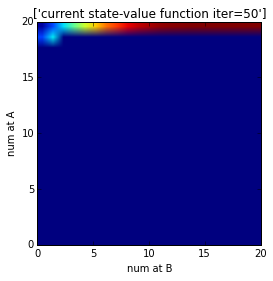

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0565916697184246e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.061923344930013e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00015721718470255533, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 8.30690066019694e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.049705505371094e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00020320018132527669, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00015205144882202148, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n

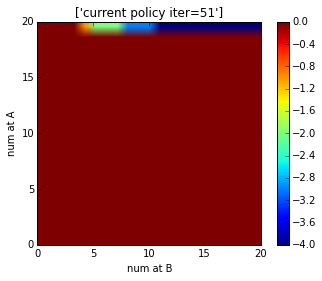

beginning policy evaluation ... 



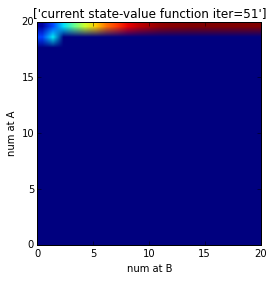

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.1034806569417317e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.0150343577067057e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 3.0350685119628906e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00012000004450480143, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.306800206502279e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00021289984385172527, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.0117244720458986e-05, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)..

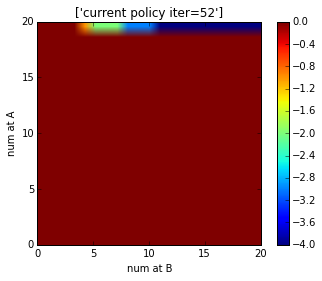

beginning policy evaluation ... 



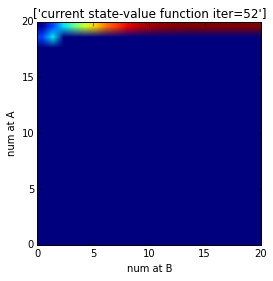

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.0832150777180989e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.148151397705078e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 3.066857655843099e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.0582815806070964e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00013993183771769205, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00016108353932698568, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00020165046056111653, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...

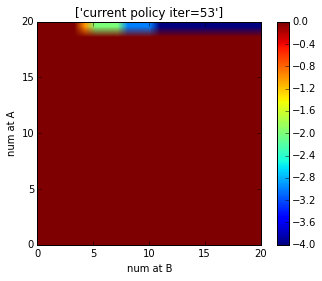

beginning policy evaluation ... 



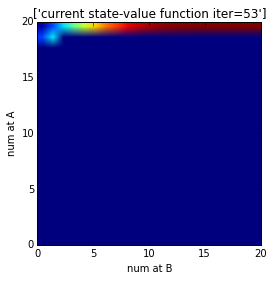

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.085201899210612e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 8.949836095174153e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 9.129842122395833e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 4.427035649617513e-05, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 5.171696345011393e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.0002129356066385905, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00016820033391316732, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n',

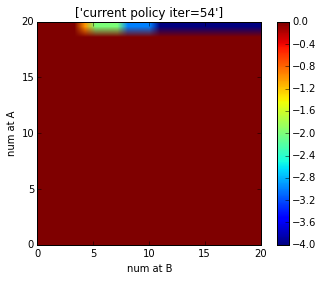

beginning policy evaluation ... 



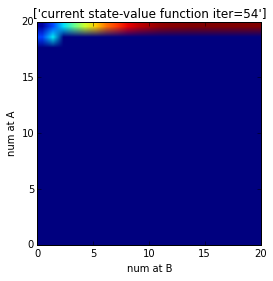

beginning policy improvement...

('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', nan, 0, 0, 0)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 1.8449624379475913e-05, 1, 0, 1)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 2.3233890533447266e-05, 2, 0, 2)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 9.146531422932943e-05, 3, 0, 3)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00011150042215983073, 4, 0, 4)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 8.58306884765625e-05, 5, 0, 5)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 0.00015395085016886394, 6, 0, 6)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n', 6.015300750732422e-05, 7, 0, 7)
('prev state took = %10.5f (min); considering state = %5d=(na=%5d,nb=%5d)...\n

KeyboardInterrupt: 

In [74]:

policyStable = 0; iterNum = 0; 
while( ~policyStable ):
  # plot the current policy:
  if( iterNum!=0 ):
    plt.figure(); 
    plt.imshow(pol_pi, extent=[0, max_n_cars, 0, max_n_cars] )
    plt.colorbar()
    plt.xlabel( 'num at B' )
    plt.ylabel( 'num at A' ) 
    plt.title( ['current policy iter='+ str(iterNum)] )
    fn=('policy_iter_%d.eps',iterNum); 
    plt.show() 
  
  
  # evaluate the state-value function under this policy: 
  V = jcr_policy_evaluation(V,pol_pi,gamma,Ra,Pa,Rb,Pb,max_num_cars_can_transfer);
  plt.figure(); 
  plt.imshow( V, extent=[0, max_n_cars, 0, max_n_cars] ) 
  plt.xlabel( 'num at B' );
  plt.ylabel( 'num at A' ); 
  plt.title( ['current state-value function iter='+ str(iterNum)] ) 
  fn=('state_value_fn_iter_%d.eps',iterNum)
  plt.show() 
  
  # compute an improved policy using the most recent as a base: 
  [pol_pi,policyStable] = jcr_policy_improvement(pol_pi,V,gamma,Ra,Pa,Rb,Pb,max_num_cars_can_transfer);
  
  iterNum=iterNum+1; 
  # if( iterNum==2 ) break; end; 

# plot the current policy:
#figure; imagesc( pol_pi ); colorbar; title( ['current policy iter=', num2str(iterNum)] ); drawnow; 



In [ ]:
plt.savefig?

In [ ]:
t

In [219]:
t[5]

IndexError: index 5 is out of bounds for axis 0 with size 3